In [ ]:
from CWScopeTesting import *
import FileFormatTesting
import MetricTesting

scope = CWScopeTesting()

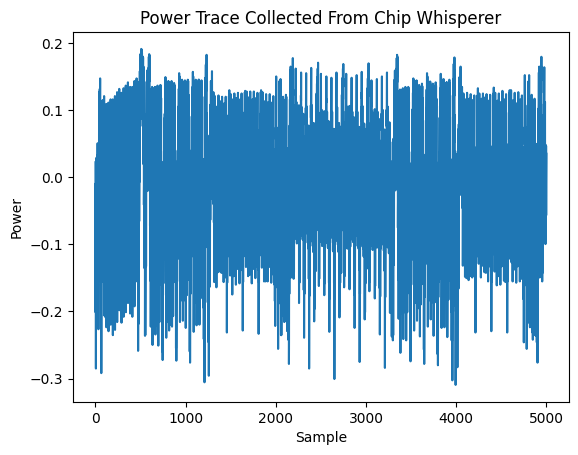

In [3]:
# Captures a single power trace and plots it
scope.capture_one_trace()